In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
#import keras
import pandas as pd

In [2]:
t = list(tf.compat.v1.python_io.tf_record_iterator('eval_laugh_speech_subset.tfrecord'))
tf_example = tf.train.Example.FromString(t[0])
tf_example.features.feature['video_id'].bytes_list.value[0].decode()

W0325 21:48:16.731237 139686950688576 deprecation.py:323] From <ipython-input-2-13334e7947c0>:1: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


'7oHaG3Ez5-4'

In [3]:
len(t)

240

In [4]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    max_len=10
    records = list(tf.compat.v1.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    print(rec_len)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size 
    j = 0

    laugh_labels = [66, 67] # change labels to cheer and applause
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, y

Using TensorFlow backend.


In [5]:
import itertools
batch_size = 32
val_gen = data_generator(batch_size,'eval_laugh_speech_subset.tfrecord')
val = list(itertools.islice(val_gen,586//32))
X = [d[0] for d in val]
y = [d[1] for d in val]
X = np.concatenate(X)
y = np.concatenate(y)

240


In [6]:
from tensorflow.keras.models import load_model
#m1 = load_model('../Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

In [7]:
p1 = m1.predict(X)

In [8]:
m2 = load_model('../Models/LSTM_SingleLayer_100Epochs.h5')

In [9]:
p2 = m2.predict(X)

In [10]:
m3 = load_model('../Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')
p3 = m3.predict(X)

In [34]:
def get_top_class_display_name(output_vector):        
    """Returns the name of the class with the highest activation"""
#     labels = ["laughter", "baby laughter", "giggle", "snicker", \
#     "belly laugh", "chuckle/chortle", "none of the above"]
    labels = [True, True, True, True, True, True, False]
    sorted_indices = list(np.argsort(output_vector)[::-1])
    return labels[sorted_indices[0]]

p5 = [get_top_class_display_name(p) for p in vp5]

In [12]:
from sklearn.metrics import roc_curve
#fpr, tpr, thresholds = roc_curve(y,p1)
#fpr2, tpr2, thresholds2 = roc_curve(y,p2)
fpr3, tpr3, thresholds3 = roc_curve(y,p3)


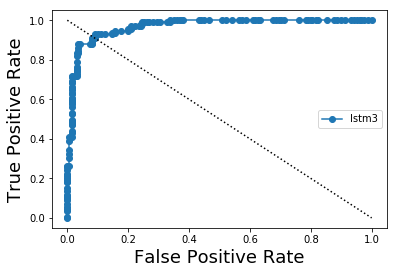

In [14]:
#plt.plot(fpr,tpr, 'o-', label='log reg')
#plt.plot(fpr2,tpr2, 'x-', label='lstm1')
plt.plot(fpr3,tpr3, 'o-', label='lstm3')

plt.plot([0,1],[1,0],'k:')
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.legend();

In [15]:
from sklearn.metrics import roc_auc_score
#print(f'Logistic Regression: {roc_auc_score(y, p1):0.2f}')
#print(f'LSTM 1: {roc_auc_score(y, p2):0.2f}')
print(f'LSTM 3: {roc_auc_score(y, p3):0.2f}')

LSTM 3: 0.97


In [16]:
from sklearn.metrics import accuracy_score
#print(f'Logistic Regression: {accuracy_score(y, p1>0.6):0.2f}')
#print(f'LSTM 1: {accuracy_score(y, p2>0.6):0.2f}')
print(f'LSTM 3: {accuracy_score(y, p3>0.6):0.2f}')

LSTM 3: 0.92


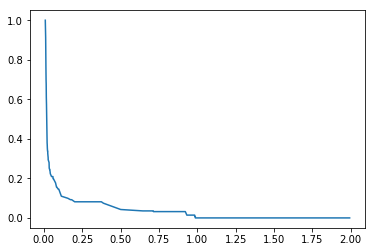

In [17]:
plt.plot(thresholds3,fpr3)

In [18]:
tpr3[8]

0.1054421768707483